In [1]:
import http.client
import json
import requests
import pandas as pd
# from pandas.io.json import json_normalize 
import numpy as np
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification
from sklearn.preprocessing import OneHotEncoder
# from pandas.io.json._table_schema import build_table_schema
import torch
# import tensorflow as tf


The plan is to make a recommender system using data from Ravelry. I'll do some exploratory data analysis first, and then make a recommender system using DistilBert. DistilBERT is just an RNN -- Large language models are just neural networks!

<h1>**Important Links**</h1> 

<h4>Ravelry API stuff</h4>

https://www.ravelry.com/pro/khadijat-durojaiye/apps <br>
https://www.ravelry.com/api <br>
https://www.ravelry.com/groups/ravelry-api/ <br>

<h4>Useful GitHub Repo</h4>

https://github.com/LilaKelland/Ravelry-Recommender-Engine/tree/main <br>

<h4>Another Useful GitHub Repo + medium article + article it was based on</h4>

https://github.com/k-christensen/Ravelry/blob/master/python_functions/ravelry_request_functions.py <br>
https://medium.com/towards-data-science/for-your-next-project-i-recommend-ab89cad53dec <br>
https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/ <br>

<h4>Medium article series</h4>

https://medium.com/data-science-at-microsoft/how-to-access-an-api-for-first-time-api-users-879002f5f58d <br>
https://medium.com/data-science-at-microsoft/collaborating-between-python-and-r-using-reticulate-25246b367957 <br>
https://medium.com/data-science-at-microsoft/turning-our-api-hackathon-into-an-end-to-end-data-science-portfolio-project-93257d165ffd <br>

<h4>blog post found on pattern classification (it's in R...)</h4>

https://datasock.wordpress.com/2015/12/01/classification-of-patterns-from-their-description/ <br>

<h4>Requests documentation</h4>

https://requests.readthedocs.io/en/latest/user/quickstart/#make-a-request <br>

<h4>Medium bookmarks for projects + link to useful article</h4>
https://medium.com/@varun.tyagi83/a-dive-into-reinforcement-learning-and-distilbert-for-movie-recommendations-ab38bd01a8e6

https://medium.com/@kodurojaiye23/list/portfolio-project-help-420e04b38e76 <br>


<h4>NVIDIA -- very very useful, more info than medium article i saved</h4>

https://www.nvidia.com/en-us/glossary/recommendation-system/ <br>

<h4>another article on recommendation systems</h4>

https://www.analyticsvidhya.com/blog/2022/06/recommender-systems-from-scratch/ <br>

<h4>Paper on LLMs as recommenders</h4>

https://arxiv.org/pdf/2308.10837


<h1>Notes...</h1>

<h3>Going to make a content based recommender</h3>

It's going to be much easier than a collaborative recommender for now (taking other users' info into account) --> maybe i can try later??

<br>

Something about generating a user profile to store information? Then a pattern pool, then determine which patterns match interests of user best


<h2>Ideas for pattern attributes to store...</h2>

<br>
pattern category (accessory, hat, cardigan, etc...), pattern attribute (bottom up, top down constriction, intarsia, etc), yarn weight

Look at items in favorites and projects....or should i just do favorityes??? rating system --> a one if in faves, 3 if in projects unrated, rating if project was made and rated!

something abt the dot product of each column and the user data column ??? is there a package that does this or does it have to be done by hand???

pattern pool is just recently popular...idk if i should do that? but also they can provide a url and pool would be patterns generated in similar search!!! i like the second thing --> maybe make it necessary to provide a url? or maybe i should keep options open and do both? focus on the 2nd thing and then maybe also do the first thing

positive samples: user likes pattern, negative samples: patterns user doesn't engage with

and then after it says i should do cosine similarity???

<h3>Read the Analytics Vidhya post!!!</h3>

searching by permalink should easily give me the pattern id, permalink is just last part of url

In [2]:
# #notes but with code

# #grabbing name of pattern for searching
# #searching by permalink should easily give me the pattern id, permalink is just last part of url
# search = 'https://www.ravelry.com/patterns/library/oslo-hat-5'
# permalink = search.split('/')[-1]
# permalink

<h1>API Access</h1>

In [3]:
#gives me personal access
authUsername = 	'39589cfb8dbfa66f26be148b1f5dc17a'
authPassword = 'bXzsSC457MZAKS4KLqFUq-GC139GBWbKtzsxFU1k'
baseurl = 'https://api.ravelry.com'

<h1>URL Extraction</h1>

<h3>FIRST I NEED TO FIGURE OUT HOW TO GET PATTERN ID FROM URL</h3>

The plan is to follow what chat gpt says and also look at github repo I found for anything extra. Looks like the other used K-Nearest Neighbors classification?

In [4]:
#first thing i need to do is somehow turn a url into a pattern...

In [5]:
#am I able to search by permalink? like is there a better way to ensure i get the right pattern with provided link?

In [6]:
#replacing permalink with pattern id gives same result!

ChatGPT suggests using pattern descriptions, but if there is no description we need to use other things to feed into the SLM --> I should look at the GitHub repos I found for help!

In [42]:
class ravutils:
    def __init__(self, authUsername, authPassword):
        self.authUsername = authUsername
        self.authPassword = authPassword
        
    def pattern_search(self, query = '',  page = 1, page_size = 100, craft = 'knitting' ):
        #returns dataframe
        #remember to search by permalink to get an exact result
        url = baseurl + f'/patterns/search.json?query={query}&page={page}&page_size={page_size}&craft={craft}'
        response = requests.get(url, auth = requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        response.close()
        norm = response.json()['patterns']
        df = pd.json_normalize(data = norm)
        return df
        
    def patternid_search(self, idlist):
        #returns dataframe 
        stridlist = [str(i) for i in idlist]
        idstring = ''
        plus = '+'
        
        if len(idlist) == 1:
            idstring += stridlist[0]
        else:
            idstring = plus.join(stridlist)
        url = baseurl + f'/patterns.json?ids={idstring}'
        response = requests.get(url, auth = requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        response.close()

        norm = response.json()['patterns'].values()
        df = pd.json_normalize(data = norm)

        cols = []
        count = 1
        for column in df.columns:
            if 'name' in column:
                cols.append(f'name_{count}')
                count+=1
                continue
            cols.append(column)
        df.columns = cols 
        return df
        
    def get_id(self, url):
        pass
        
    def get_favorites(self, rav_username = 'khadarty', types = 'pattern', query = '', deep_search = '', page = 1, page_size = 100):
        #gets list of pattern favorites
        url = baseurl + f"/people/{rav_username}/favorites/list.json?types={types}&query={query}&deep_search={deep_search}&page={page}&page_size={page_size}"
        response= requests.get(url, auth = requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        response.close()
        
        norm = response.json()['favorites']
        df = pd.json_normalize(data = norm)
        return df
    def get_queue(self, rav_username = 'khadarty', query = '', page = 1, page_size = 100):
        #define URL
        url = baseurl + f'/people/{rav_username}/queue/list.json?query={query}&page={page}&page_size={page_size}' 
        #make the request
        response = requests.get(url, auth=requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        #close the connection
        response.close()
        norm = response.json()['queued_projects']
        df = pd.json_normalize(data = norm)
        return df
    def get_projects(self, rav_username = 'khadarty', page = 1, page_size = 100, collections = '', sort = ''):
        #define URL
        url = baseurl + f'/projects/{rav_username}/list.json?page={page}&page_size={page_size}&sort={sort}&include={collections}' 
        #make the request
        response = requests.get(url, auth=requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        #close the connection
        response.close()
        norm = response.json()['projects']
        df = pd.json_normalize(data = norm)
        return df
    # def getpattern_notes(self, idlist): #right now this just works for one pattern
    #     #searching for pattern with id search
    #     description = self.patternid_search(idlist)['notes']
    #     return description 

In [43]:
#allowing me to see all rows and columns in a dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [44]:
#creating instance of thingy thing 
meep = ravutils(authUsername, authPassword)

In [46]:
meep.get_projects(rav_username = 'madetobemad')

,comments_count,completed,craft_id,created_at,favorites_count,id,made_for,made_for_user_id,name,pattern_id,permalink,progress,project_status_changed,project_status_id,rating,size,started,updated_at,user_id,pattern_name,craft_name,status_name,tag_names,photos_count,ends_per_inch,picks_per_inch,gauge,row_gauge,gauge_repeats,gauge_divisor,gauge_pattern,completed_day_set,started_day_set,links.self.href,first_photo.id,first_photo.sort_order,first_photo.user_id,first_photo.x_offset,first_photo.y_offset,first_photo.square_url,first_photo.medium_url,first_photo.thumbnail_url,first_photo.small_url,first_photo.medium2_url,first_photo.small2_url,first_photo.caption,first_photo.caption_html,first_photo.copyright_holder
0,0,None,2,2023/06/23 10:16:22 -0400,2,32525628,,None,Zakkuri #2,1302040,zakkuri-cardigan,100.0,2023/06/25 14:32:46 -0400,2,4.0,,None,2023/06/25 14:32:46 -0400,9816345,Zakkuri Cardigan,Knitting,Finished,[],1,None,None,None,None,None,None,,False,False,https://www.ravelry.com/projects/madetobemad/z...,122150651,1,9816345,-5,-35,https://images4-g.ravelrycache.com/uploads/mad...,https://images4-g.ravelrycache.com/uploads/mad...,https://images4-f.ravelrycache.com/uploads/mad...,https://images4-g.ravelrycache.com/uploads/mad...,https://images4-a.ravelrycache.com/uploads/mad...,https://images4-f.ravelrycache.com/uploads/mad...,None,None,None
1,0,None,2,2023/06/23 10:18:23 -0400,0,32525642,,None,Zakkuri #2,1302040,zakkuri-cardigan-2,NaN,2023/06/23 10:19:22 -0400,1,NaN,,None,2023/06/23 10:19:22 -0400,9816345,Zakkuri Cardigan,Knitting,In progress,[],1,None,None,None,None,None,None,,False,False,https://www.ravelry.com/projects/madetobemad/z...,122150661,1,9816345,-35,-5,https://images4-f.ravelrycache.com/uploads/mad...,https://images4-f.ravelrycache.com/uploads/mad...,https://images4-f.ravelrycache.com/uploads/mad...,https://images4-f.ravelrycache.com/uploads/mad...,https://images4-a.ravelrycache.com/uploads/mad...,https://images4-g.ravelrycache.com/uploads/mad...,None,None,None


In [10]:
# searching for patterns with ids
idsearch1 = meep.patternid_search([523829,7364422,857493])
# getting my favorites, i specified patterns, but you can get all favorites
kdfaves = meep.get_favorites(rav_username = 'khadarty')
# getting ids of my faves
kdfavesid = kdfaves['favorited.id'].values
# getting the notes of all of the patterns in my favorites list by doing an id search
kdfavesnotes = meep.patternid_search(kdfavesid)[['notes']]
#getting my queue
kdqueue = meep.get_queue(rav_username = 'khadarty')
#get ids of queue
kdqueueid = kdqueue['pattern_id'].values
#getting notes of queue patterns 
kdqueuenotes = meep.patternid_search(kdqueueid)[['notes']]


### Should get patterns in queue, in favorites, and in projects

In [11]:
kdqueuenotes

,notes
0,Note: Pattern Revised & Updated on 04-26-22\r\...
1,**Sizes**\r\n\r\n\r\nXS (S) M (L) XL (XXL)\r\n...
2,SKILL LEVEL: Intermediate\r\n\r\nTECHNIQUES US...


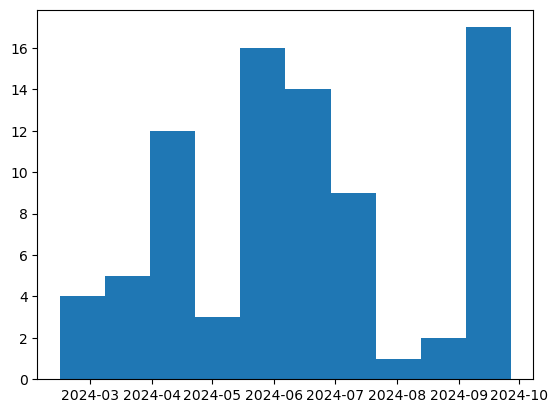

In [12]:
#i could plot the number of favorited patterns over time --> i should figure out how to do date
#bar graph of favorites by pattern type (although i'm struggling to find pattern type)
#I have 83 things in my favorites

#converting strings to datetime objects, plotting histogram of dates --> shows how many patterns i favorited every months
kdfaves['datetime'] = pd.to_datetime(kdfaves['created_at'], errors='coerce', utc = True)
kdfaves['datetime']
kdfaves['date'] = kdfaves['datetime'].dt.date
plt.hist(kdfaves['date'])
plt.xlabel('')
plt.show()

In [13]:
kdfaves

,created_at,id,type,tag_list,comment,favorited.id,favorited.name,favorited.permalink,favorited.first_photo.id,favorited.first_photo.sort_order,favorited.first_photo.user_id,favorited.first_photo.x_offset,favorited.first_photo.y_offset,favorited.first_photo.square_url,favorited.first_photo.medium_url,favorited.first_photo.thumbnail_url,favorited.first_photo.small_url,favorited.first_photo.medium2_url,favorited.first_photo.small2_url,favorited.first_photo.caption,favorited.first_photo.caption_html,favorited.first_photo.copyright_holder,favorited.designer.crochet_pattern_count,favorited.designer.favorites_count,favorited.designer.id,favorited.designer.knitting_pattern_count,favorited.designer.name,favorited.designer.patterns_count,favorited.designer.permalink,favorited.designer.users,favorited.pattern_author.crochet_pattern_count,favorited.pattern_author.favorites_count,favorited.pattern_author.id,favorited.pattern_author.knitting_pattern_count,favorited.pattern_author.name,favorited.pattern_author.patterns_count,favorited.pattern_author.permalink,favorited.pattern_author.users,favorited.pattern_sources,datetime,date
0,2024/09/27 10:36:31 -0400,491249289,pattern,,None,86740,Acorn,acorn-3,32843688,1,2075065,1,-37,https://images4-g.ravelrycache.com/uploads/Sas...,https://images4-g.ravelrycache.com/uploads/Sas...,https://images4-g.ravelrycache.com/uploads/Sas...,https://images4-g.ravelrycache.com/uploads/Sas...,https://images4-a.ravelrycache.com/uploads/Sas...,https://images4-g.ravelrycache.com/uploads/Sas...,None,None,Sasha Kagan,35,539,2396,179,Sasha Kagan,214,sasha-kagan,"[{'id': 2075065, 'username': 'SashaKagan', 'ti...",35,539,2396,179,Sasha Kagan,214,sasha-kagan,"[{'id': 2075065, 'username': 'SashaKagan', 'ti...","[{'amazon_rating': None, 'amazon_reviews': Non...",2024-09-27 14:36:31+00:00,2024-09-27
1,2024/09/26 17:57:03 -0400,491174352,pattern,,None,611851,Lichen,lichen-6,52145348,1,101165,-9,-78,https://images4-f.ravelrycache.com/uploads/Dan...,https://images4-f.ravelrycache.com/uploads/Dan...,https://images4-f.ravelrycache.com/uploads/Dan...,https://images4-g.ravelrycache.com/uploads/Dan...,https://images4-a.ravelrycache.com/uploads/Dan...,https://images4-f.ravelrycache.com/uploads/Dan...,None,None,DanDoh,67,9122,6295,170,Yumiko Alexander,237,yumiko-alexander,"[{'id': 101165, 'username': 'DanDoh', 'tiny_ph...",67,9122,6295,170,Yumiko Alexander,237,yumiko-alexander,"[{'id': 101165, 'username': 'DanDoh', 'tiny_ph...","[{'amazon_rating': None, 'amazon_reviews': Non...",2024-09-26 21:57:03+00:00,2024-09-26
2,2024/09/26 17:56:12 -0400,491174251,pattern,,None,7315139,Lace Polo,lace-polo,127710927,1,2281285,0,-19,https://images4-g.ravelrycache.com/uploads/Mie...,https://images4-f.ravelrycache.com/uploads/Mie...,https://images4-f.ravelrycache.com/uploads/Mie...,https://images4-g.ravelrycache.com/uploads/Mie...,https://images4-a.ravelrycache.com/uploads/Mie...,https://images4-g.ravelrycache.com/uploads/Mie...,None,None,None,0,1733,85171,145,Spektakelstrik - Mie Firring,145,spektakelstrik---mie-firring,"[{'id': 2281285, 'username': 'MieFirring', 'ti...",0,1733,85171,145,Spektakelstrik - Mie Firring,145,spektakelstrik---mie-firring,"[{'id': 2281285, 'username': 'MieFirring', 'ti...","[{'amazon_rating': None, 'amazon_reviews': Non...",2024-09-26 21:56:12+00:00,2024-09-26
3,2024/09/26 17:55:47 -0400,491174210,pattern,,None,7356796,Crumpet Camisole,crumpet-camisole,131555233,1,1917982,0,-28,https://images4-g.ravelrycache.com/uploads/par...,https://images4-f.ravelrycache.com/uploads/par...,https://images4-f.ravelrycache.com/uploads/par...,https://images4-f.ravelrycache.com/uploads/par...,https://images4-a.ravelrycache.com/uploads/par...,https://images4-g.ravelrycache.com/uploads/par...,None,None,None,0,3954,107688,47,Park Williams,47,park-williams,"[{'id': 1917982, 'username': 'parkandknit', 't...",0,3954,107688,47,Park Williams,47,park-williams,"[{'id': 1917982, 'username': 'parkandknit', 't...","[{'amazon_rating': None, 'amazon_reviews

<h3>Generate user id</h3>

In [14]:
#ummm do this later

<h3>Pattern pool stuff</h3>

In [16]:
idsearch1['pattern_type.id']

0     4
1    17
2     4
Name: pattern_type.id, dtype: int64

In [17]:
#item pool is everything on ravelry

<h1>Pattern Data Preprocessing</h1>

<h2>What info from patterns I should keep</h2>
<ol>
    <li>Pattern title and description --> definitely need notes from description</li>
    <li>Yarn weight --> 'name' or 'wpi' or 'ply'</li>
    <li>Hook/needle size ---> gauge_description, yardage, </li>
    <li>tags/attributes --> clothing (t/f), name (there are two columns called name), pattern_attributes, pattern_categories</li>
    <li>difficulty level --> difficulty_average, difficulty_count</li>
    <li>finished object attributes --> range of sizes available, yardage, yardage_max</li>
</ol>

I'll have to do some text cleaning 


stuff from other notebook I found ---->

Stuff that was kept from other pattern recommendation system:


pattern_type_names --> couldn't find

photos_url --> won't include for now

pattern_attributes ---> can't find

categories ---> can't find

In [19]:
#trying to get together a dataset -->


#'df' here would be the dataframe output of an id search

# pattern notes --> got that already ***********************
# df.iloc[:,58] (['name_2']) for yarn weight --> start here but i could do wpi or ply later if i wanted to ****************
# df['gauge_description'] for hook and needle size --> or i could do df['gauge']/df['gauge_divisor']
# df.iloc[:,79] ([name_5]) --> for name, clothing or not clothing??? idk *******************
# df['difficulty_average'] and df['difficulty_count']
# df['yardage'] df['yardage_max']--> 

#i can also add cost as an attribute but i can do that later

## Creation of pattern pool....

### for now I'll start small, just 1000 patterns in pool and just base it off of my favorites (then i can move on to in queue and projects)

In [49]:
#first start with just a few patterns, about 1000 patterns...
patt_pool1 = meep.pattern_search(page_size = 1000)

In [53]:
poolidsearch = meep.patternid_search(patt_pool1['id'].values)

In [54]:
train_df = poolidsearch[['rating_average', 'queued_projects_count', 'rating_count', 'difficulty_average', 'difficulty_count', 'free', 'id', 'permalink'
                 , 'favorites_count', 'projects_count', 'name_1', 'gauge', 'gauge_divisor', 'downloadable', 'pattern_needle_sizes'
                 , 'difficulty_average', 'yardage', 'yardage_max', 'name_5', 'notes', 'yarn_weight_description'
                , 'generally_available', 'pattern_type.clothing']]
# train_df['gauge_per_inch'] = train_df['gauge'].div(train_df['gauge_divisor'], axis = 0)
train_df

,rating_average,queued_projects_count,rating_count,difficulty_average,difficulty_count,free,id,permalink,favorites_count,projects_count,name_1,gauge,gauge_divisor,downloadable,pattern_needle_sizes,difficulty_average,yardage,yardage_max,name_5,notes,yarn_weight_description,generally_available,pattern_type.clothing
0,4.488073,3784,2725.0,2.434798,2891.0,True,3156,basic-ribbed-socks,22691,13075,Basic Ribbed Socks,32.00,4.0,True,"[{'id': 21, 'us': '1½', 'metric': 2.5, 'us_ste...",2.434798,370.0,NaN,Socks,"*From Pattern Notes:*\r\n\r\n> ""I love to solv...",Fingering (14 wpi),2006/04/01 00:00:00 -0500,True
1,4.650853,1963,2403.0,2.444625,2465.0,False,5241,sock-recipe-a-good-plain-sock,11531,19234,"Sock Recipe: A Good, Plain Sock",NaN,NaN,False,[],2.444625,NaN,NaN,Socks,Knit from the cuff-down.\r\n\r\nThis recipe be...,Any gauge - designed for any gauge,2006/03/01 00:00:00 -0500,True
2,4.839009,1035,323.0,1.673139,309.0,True,91147,losy-hat,6775,2424,LOSY Hat,22.00,4.0,True,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...",1.673139,300.0,350.0,Hat,LOSY stands for left over sock yarn I know eve...,DK (11 wpi),2008/10/21 14:56:12 -0400,True
3,4.611258,3353,1510.0,3.802236,1431.0,False,106061,riddari,28993,7031,Riddari,18.00,4.0,True,"[{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...",3.802236,NaN,NaN,Pullover,[Riddari in Icelandic][1]\r\n\r\n[Riddari in G...,Aran (8 wpi),2008/01/01 00:00:00 -0500,True
4,4.658333,5594,3000.0,2.354481,2979.0,True,111517,simple-skyp-socks,33970,11969,Simple Skyp Socks,7.00,1.0,True,"[{'id': 2, 'us': '2 ', 'metric': 2.75, 'us_ste...",2.354481,NaN,NaN,Socks,>This pattern had previously been available as...,Sport (12 wpi),2009/02/01 00:00:00 -0500,True
5,4.629096,8250,3815.0,1.734880,4051.0,True,119278,boneyard-shawl,48245,11339,Boneyard Shawl,NaN,NaN,True,"[{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...",1.734880,600.0,NaN,Shawl/Wrap,*This simple triangular shawl begins at the to...,DK (11 wpi),2009/04/19 20:20:50 -0400,True
6,4.691837,10337,5880.0,1.583530,5926.0,True,124400,sockhead-slouch-hat,66326,29638,Sockhead Slouch Hat,32.00,4.0,True,"[{'id': 20, 'us': '2½', 'metric': 3.0, 'us_ste...",1.583530,155.0,415.0,Child,Version Four (V4) is now available! **#sockhea...,Fingering (14 wpi),2009/05/25 16:17:05 -0400,True
7,4.664316,13680,9360.0,2.421053,9177.0,True,130787,hermiones-everyday-socks,87752,41604,Hermione's Everyday Socks,36.00,4.0,True,"[{'id': 1, 'us': '1 ', 'metric': 2.25, 'us_ste...",2.421053,350.0,400.0,Socks,"Hermione, as described in J.K. Rowling’s Harry...",Fingering (14 wpi),2009/07/09 11:36:45 -0400,True
8,4.582304,11451,4939.0,1.942650,5231.0,True,181549,the-age-of-brass-and-steam-kerchief,74403,15594,The Age of Brass and Steam Kerchief,18.00,4.0,True,"[{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...",1.942650,230.0,370.0,Shawl/Wrap,A unisex triangular kerchief/shawl knitted in ...,DK (11 wpi),2010/05/24 13:02:22 -0400,True
9,4.683107,9557,9590.0,1.779531,10015.0,False,211562,hitchhiker,58824,36218,Hitchhiker,21.00,4.0,True,"[{'id': 20, 'us': '2½', 'metric': 3.0, 'us_ste...",1.779531,569.0,574.0,Scarf,"*Pattern available in English, French, German,...",Fingering (14 wpi),2010/11/15 07:59:40 -0500,True


In [55]:
train_df['notes'] = train_df['notes'].str.replace('\r', ' ').str.replace('\n', ' ').str.replace('*', ' ').str.replace('#', ' ')

/var/folders/yv/z1dch3dj5wx3188lknqcwcc00000gn/T/ipykernel_12019/844015608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['notes'] = train_df['notes'].str.replace('\r', ' ').str.replace('\n', ' ').str.replace('*', ' ').str.replace('#', ' ')


<h1>Loading and Embedding Data Using SLM</h1>

## Feeding into DistilBERT

In [25]:
train_df.iloc[0].notes

'Interweave SKU: EP0116     Pattern Description from Interweave Online Store:   Heading out for Saturday brunch with friends at your favorite neighborhood spot? Better bring Heather Lodinsky\'s comfy hoodie in case the weather turns chilly. Tahki\'s Donegal Tweed wool singles yarn delivers beautiful cable structure and insulation from the cold. Now offered in extended sizes. See the CPH Plus Size Galleries on Knitting Daily!       Finished Size:   Sizes 32 (36, 40, 44, 48, 52, 56, 60)" bust.      Yarn:   Tahki Donegal Tweed (100% wool; 183 yd (167 m)/110 g):  803 yellow-green OR  869 dark-taupe (brown): 6 (7, 8, 9, 10, 16, 18, 20) skeins.      Yarn weight:    4 - Medium      Gauge:   17 sts and 24 rows = 4" in St st on larger needles.      Needles:   Sizes 6 (4 mm) and 8 (5 mm) needles, or size to achieve gauge, Size 6 (4 mm): 32-40" circular needle      Notions:   Cable needle (cn), Stitch markers, Stitch holders, Yarn needle, Buttons (optional), Crochet hook (optional)      Originall

In [21]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',do_lower_case = True)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

/Users/khadarty/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
# tokenizing first description
text = train_df.iloc[0].notes
tokens = tokenizer.tokenize(text)

First description contains 267 wordpiece tokens.


In [31]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

#tokenizing pattern descriptions and feeding them into the model?
def get_embeddings(descriptions):
    inputs = tokenizer(descriptions, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# Create embeddings for each pattern
pattern_embeddings = [get_embeddings(desc) for desc in train_df['notes']]
    
    

### Basically the more preprocessing the higher the performance...

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity

# # Assuming user_embedding and pattern_embeddings are numpy arrays
# similarities = cosine_similarity(user_embedding, pattern_embeddings)
# recommendations = np.argsort(similarities, axis=1)[:, ::-1]

In [20]:
# #load model and tokenizer
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# #tokenize pattern description --> figure out what this means
# inputs = tokenizer(description, return_tensors = 'pt', padding = True, truncation = True)

# #get embeddings for pattern description
# with torch.no_grad():
#     outputs = model(**inputs)
#     pattern_embedding = outputs.last_hidden_state.mean(dim = 1)

<h1>Comparing Input with Other Patterns</h1>

In [21]:
#this us where gpt used cosine similarity, but I'm wondering if i can just use K Nearest Neighbors

<h1>Display Recs</h1>

In [22]:
#printing pattern names and URLs

<h1>Maybe (Optionally) Incorportate Additional Metadata</h1>

<h1>Deploy Recommender</h1>

In [23]:
#fastapi or flask